In [1]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from notebook_utils import get_distribution_over_vocabulary, get_mlm_results, get_downstream_results, corpus_sizes

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
FIGURE_DIR = "/home/limisiewicz/my-luster/entangled-in-scripts/output/figures"
TABLE_DIR =  "/home/limisiewicz/my-luster/entangled-in-scripts/output/tables"

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18


## Parameteres

In [6]:
name_map = {
    'multilingual': 'Unigram',
    'bpe': 'BPE',
    'merged': 'TokMix',
    'nooverlap': 'NoOverlap'
}

In [7]:
languages = ('ar', 'tr', 'zh','el', 'es', 'en')
alpha = 0.25
tokenization_types = ('multilingual', 'bpe', 'merged', 'nooverlap')
N_vocab = 120000


ft_type = 'PROBE'

In [8]:
in_lang_results = pd.DataFrame(columns=['task', 'metric', 'tokenizer'] + list(languages) + ['All'] )
in_lang_stds = pd.DataFrame(columns=['task', 'metric', 'tokenizer'] + list(languages) + ['All'] )

# Tokenizers and Distributions over Vocabulary

In [9]:
vocab_distributions = dict()
vocab_dist_arrays = dict()
vocab_frequencies = dict()

for tok_type in tokenization_types:
    vocab_distributions[tok_type], vocab_frequencies[tok_type] \
        = get_distribution_over_vocabulary(tok_type, alpha, N_vocab, languages)
    vocab_dist_arrays[tok_type] = {lang: np.array(list(vocab_distributions[tok_type][lang].values()))
                                   for lang in languages + ('All',)}

## Probability Distribution Function
The tokens are sorted by frequency

In [10]:
def boxplot_across_languages(res, metric, languages, task=None):
    if task:
        metric_df = pd.melt(res[(res.metric == metric) & (res.task == task)], id_vars='tokenizer',
                     value_vars=languages, value_name=metric, var_name="language")
    else:
        metric_df = pd.melt(res[res.metric == metric], id_vars='tokenizer',
                     value_vars=languages, value_name=metric, var_name="language")
    sns.boxplot(data=metric_df, x=metric, y='tokenizer')

<Figure size 640x480 with 0 Axes>

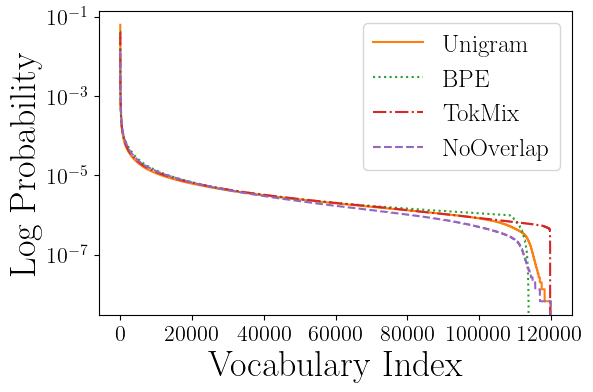

In [11]:
line_styles=['-', ':', '-.', '--']
colors= ["C1", "C2", "C3", "C4"]
plt.figure()
f, ax = plt.subplots(figsize=(6.5, 4.5))
for t_idx, tokenization in enumerate(tokenization_types):
    sorted_data = np.sort(vocab_dist_arrays[tokenization]['All'])[::-1]
    ax.plot(sorted_data,c=colors[t_idx],ls=line_styles[t_idx], label=name_map[tokenization])
ax.set_yscale('log')
ax.set_ylabel('Log Probability')
ax.set_xlabel('Vocabulary Index')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_log_pdf.pdf"), dpi=300)
plt.show()

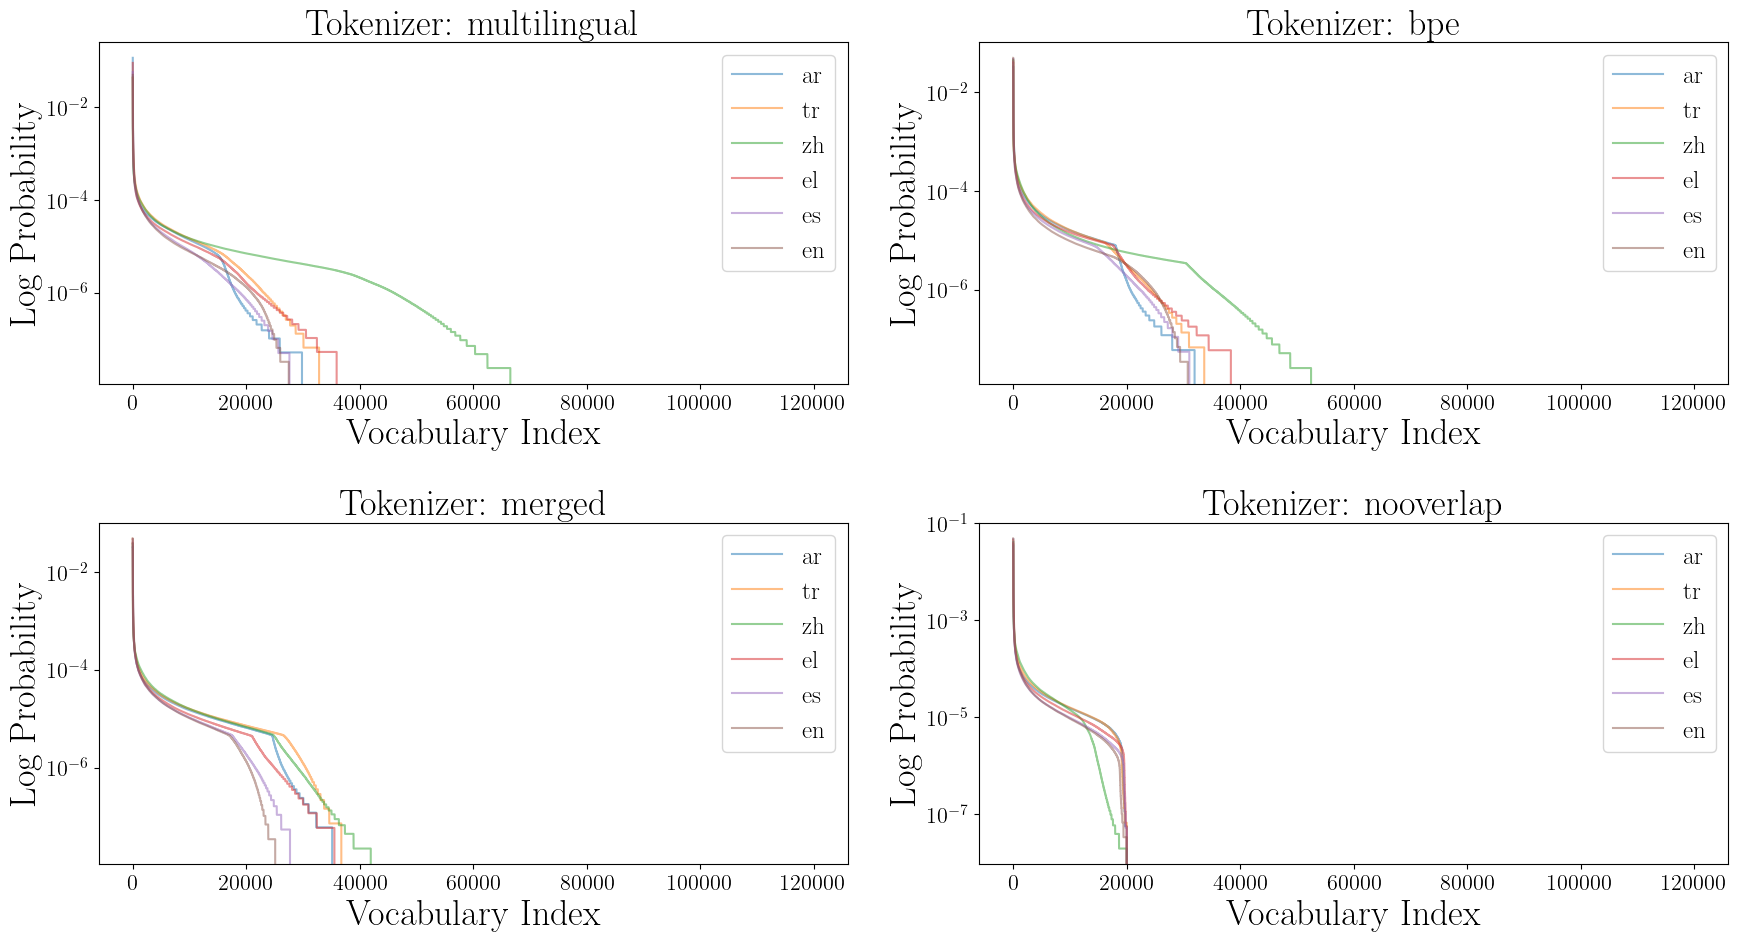

In [12]:
fig, axes = plt.subplots(2, 2,figsize=(18, 10))
axes = axes.ravel()
for t_idx, tokenization in enumerate(tokenization_types):
    ax = axes[t_idx]
    for lang in languages:
        sorted_lang_data = np.sort(vocab_dist_arrays[tokenization][lang])[::-1]
        axes[t_idx].plot(sorted_lang_data, label=lang, alpha=0.5)
        axes[t_idx].set_ylabel('Log Probability')
        axes[t_idx].set_xlabel('Vocabulary Index')
        axes[t_idx].legend()
    axes[t_idx].set_yscale('log')
    axes[t_idx].set_title(f"Tokenizer: {tokenization}")
    axes[t_idx].legend()

    
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_log_pdf_each_language.pdf"), dpi=300)
plt.show()

## Cumulative Distribution Function

<Figure size 640x480 with 0 Axes>

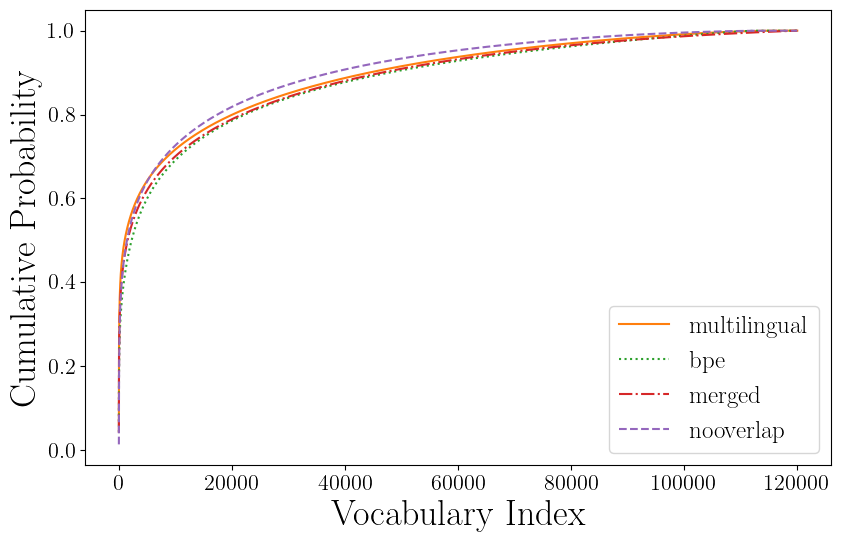

In [13]:
line_styles=['-', ':', '-.', '--']
colors= ["C1", "C2", "C3", "C4"]
plt.figure()
f, ax = plt.subplots(figsize=(9, 6))
for t_idx, tokenization in enumerate(tokenization_types):
    sorted_data = np.sort(vocab_dist_arrays[tokenization]['All'])[::-1]
    cdf = np.cumsum(sorted_data)
    ax.plot(cdf,c=colors[t_idx],ls=line_styles[t_idx], label=tokenization)

ax.set_ylabel('Cumulative Probability')
ax.set_xlabel('Vocabulary Index')
ax.legend()


plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_cdf.pdf"), dpi=300)
plt.show()

## Cumulative Distribution Functions (for specific languages)

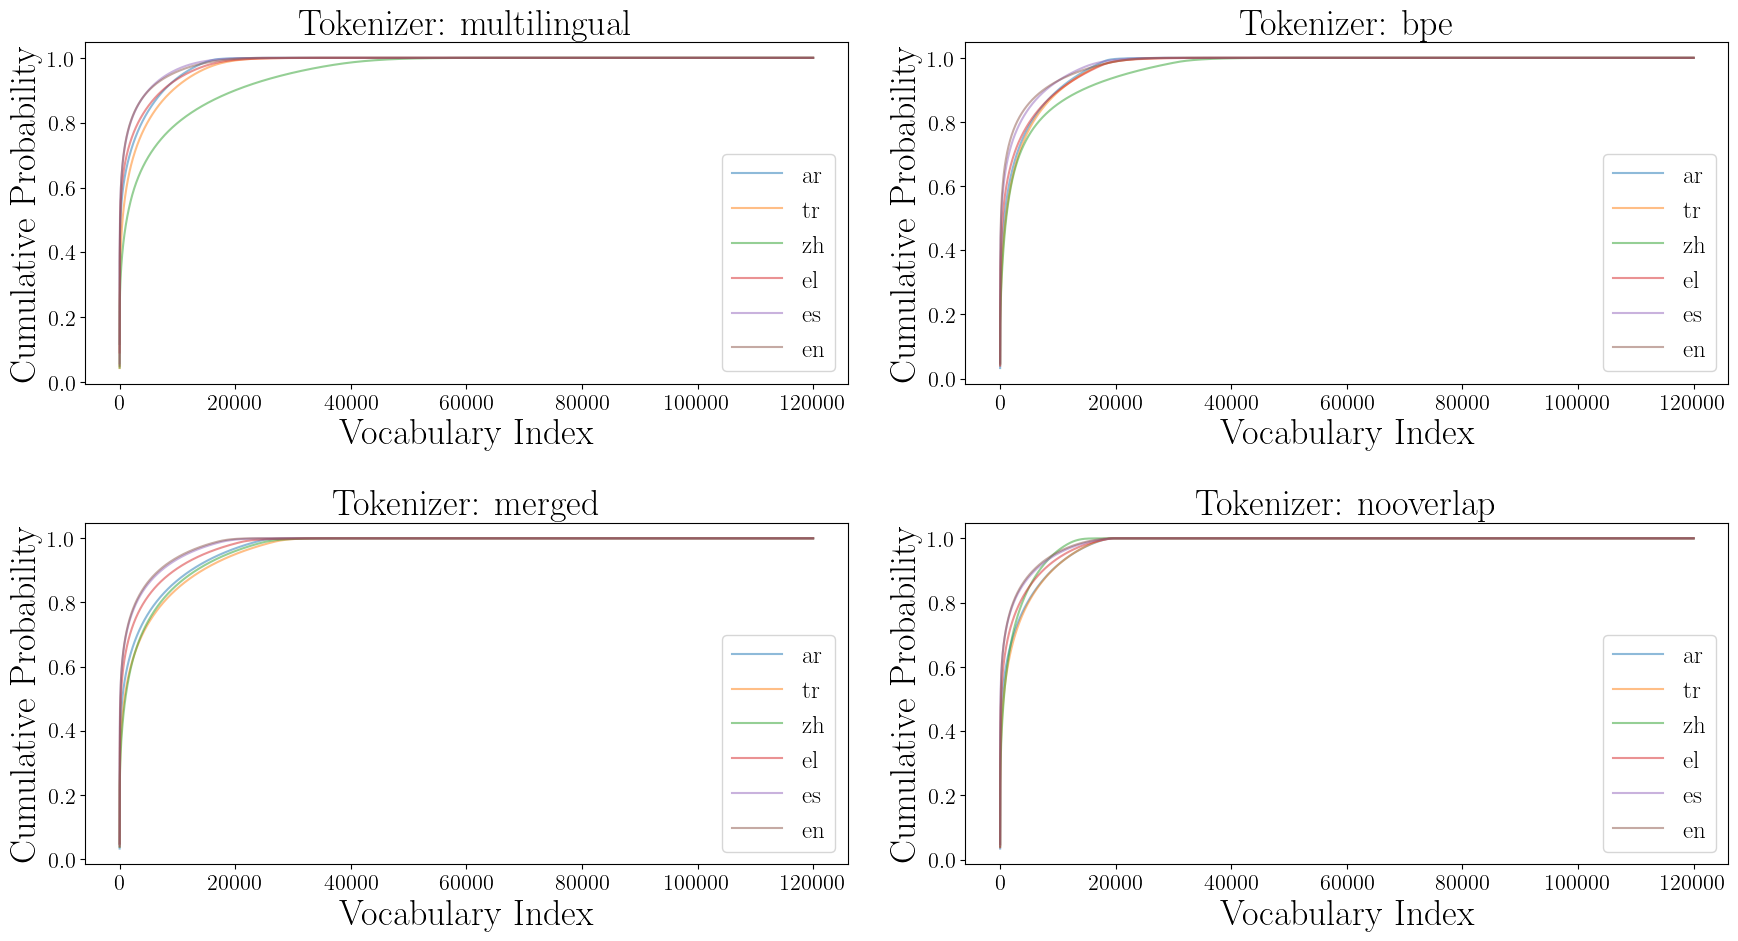

In [14]:
fig, axes = plt.subplots(2, 2,figsize=(18, 10))
axes = axes.ravel()
for t_idx, tokenization in enumerate(tokenization_types):
    ax = axes[t_idx]
    for lang in languages:
        sorted_lang_data = np.sort(vocab_dist_arrays[tokenization][lang])[::-1]
        axes[t_idx].plot(np.cumsum(sorted_lang_data), label=lang, alpha=0.5)
        axes[t_idx].set_ylabel('Cumulative Probability')
        axes[t_idx].set_xlabel('Vocabulary Index')
        axes[t_idx].legend()
    axes[t_idx].set_title(f"Tokenizer: {tokenization}")
    axes[t_idx].legend()

    
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_cdf_each_language.pdf"), dpi=300)
plt.show()

## Average Ranks of Vocabulary Units (Vocab allocation)

In [15]:
def compute_rank_average(probabilites):
    sorted_probabilities = np.sort(probabilites)[::-1]
    r_e = np.sum(sorted_probabilities * np.arange(len(probabilites)))
    return r_e

def compute_rank_std(probabilites):
    sorted_probabilities = np.sort(probabilites)[::-1]
    r_e = np.sum(sorted_probabilities * np.arange(len(probabilites)))
    r_e2 = np.sum(sorted_probabilities * (np.arange(len(probabilites)) ** 2.))
    
    return np.sqrt(r_e2 - (r_e ** 2.))
    

In [16]:
for tokenization in tokenization_types:
    rank_est = {'task': 'allocation', 'metric': 'Avg. Rank', 'tokenizer': tokenization} 
    rank_std = {'task': 'allocation', 'metric': 'Avg. Rank', 'tokenizer': tokenization} 

    for lang, probabilities in vocab_dist_arrays[tokenization].items():
        rank_est[lang] = compute_rank_average(probabilities)
        rank_std[lang] = compute_rank_std(probabilities)
        
    rank_est['All'] /= len(languages)
    rank_std['All'] /= np.sqrt(len(languages))

    in_lang_results = in_lang_results.append(rank_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(rank_std, ignore_index=True)

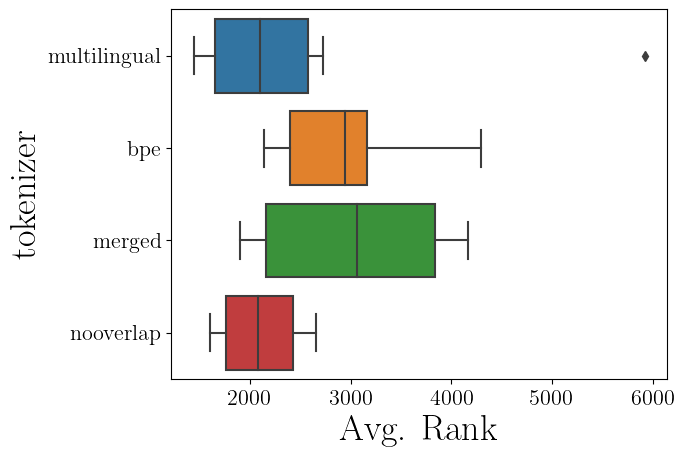

In [17]:
boxplot_across_languages(in_lang_results, 'Avg. Rank', languages)

## Comparision of token numbers

In [18]:
for tokenization in tokenization_types:
    cpt_est = {'task': 'allocation', 'metric': 'CPT', 'tokenizer': tokenization} 
    cpt_std = {'task': 'allocation', 'metric': 'CPT', 'tokenizer': tokenization} 
    
    all_corpora_size = 0
    
    for lang in languages:
        cpt_est[lang] = corpus_sizes[lang][f"alpha{alpha}"] / np.sum(list(vocab_frequencies[tokenization][lang].values())) 
        cpt_std[lang] = 0
        all_corpora_size += corpus_sizes[lang][f"alpha{alpha}"] 
        
    cpt_est['All'] = all_corpora_size /  np.sum(list(vocab_frequencies[tokenization]['All'].values()))
    cpt_std['All'] = 0
        
    in_lang_results = in_lang_results.append(cpt_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(cpt_std, ignore_index=True)

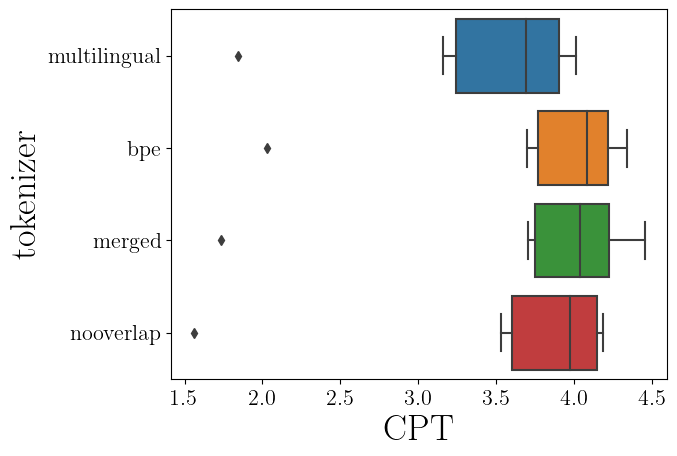

In [19]:
boxplot_across_languages(in_lang_results, 'CPT', languages)

In [20]:
# for tokenization in tokenization_types:
#     ut_est = {'task': 'allocation', 'metric': 'Unique Tokens', 'tokenizer': tokenization} 
#     ut_std = {'task': 'allocation', 'metric': 'Unique Tokens', 'tokenizer': tokenization}
    
#     nt_est = {'task': 'allocation', 'metric': 'Number Tokens', 'tokenizer': tokenization}
#     nt_std = {'task': 'allocation', 'metric': 'Number Tokens', 'tokenizer': tokenization}
              
#     ratio_est = {'task': 'allocation', 'metric': 'Uniqe Ratio', 'tokenizer': tokenization}
#     ratio_std  = {'task': 'allocation', 'metric': 'Uniqe Ratio', 'tokenizer': tokenization}
    
    
#     for lang in languages:
#         ut_est[lang] = np.sum(vocab_dist_arrays[tokenization][lang] > 0.)
#         nt_est[lang] = np.sum(list(vocab_frequencies[tokenization][lang].values()))
#         ratio_est[lang] = nt_est[lang] / ut_est[lang]
                  
#         ut_std[lang] = 0.
#         nt_std[lang] = 0.
#         ratio_std[lang] = 0.
                  
#     in_lang_results = in_lang_results.append(ut_est, ignore_index=True)
#     in_lang_stds = in_lang_stds.append(ut_std, ignore_index=True)
                  
#     in_lang_results = in_lang_results.append(nt_est, ignore_index=True)
#     in_lang_stds = in_lang_stds.append(nt_std, ignore_index=True)
                  
#     in_lang_results = in_lang_results.append(ratio_est, ignore_index=True)
#     in_lang_stds = in_lang_stds.append(ratio_est, ignore_index=True)

# Results for LMs

## Original task performance (MRR / BPC)

In [21]:
mlm_results = {tok_type: get_mlm_results(tok_type, alpha, N_vocab, languages) for 
                      tok_type in tokenization_types}

Mean reciprocal rank

In [22]:


for tokenization in tokenization_types:
    mrr_est = {'task': 'LM', 'metric': 'MRR', 'tokenizer': tokenization} 
    mrr_std = {'task': 'LM', 'metric': 'MRR', 'tokenizer': tokenization} 
    
    mrr_est.update(mlm_results[tokenization]['mrr'])
    mrr_est['All'] = np.average(list(mlm_results[tokenization]['mrr'].values()))
    
    for lang in languages:
        mrr_std[lang] = 0.
    mrr_std['All'] = 0.

    in_lang_results = in_lang_results.append(mrr_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(mrr_std, ignore_index=True)

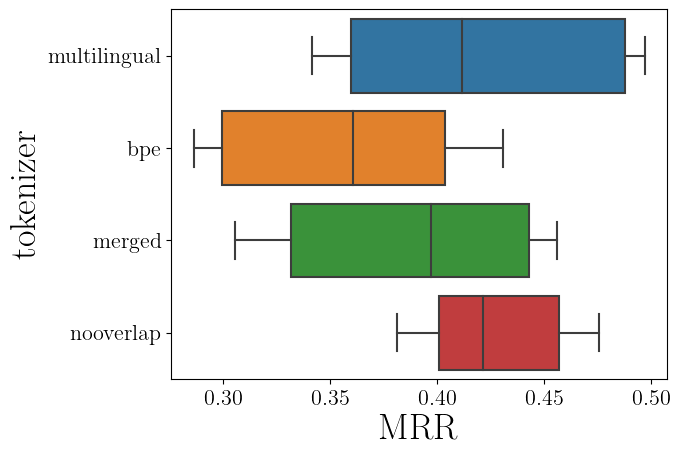

In [23]:
boxplot_across_languages(in_lang_results, 'MRR', languages)

Bits per character

In [24]:
for tokenization in tokenization_types:
    mrr_est = {'task': 'LM', 'metric': 'BPC', 'tokenizer': tokenization} 
    mrr_std = {'task': 'LM', 'metric': 'BPC', 'tokenizer': tokenization} 
    
    mrr_est.update(mlm_results[tokenization]['bpc'])
    mrr_est['All'] = np.average(list(mlm_results[tokenization]['bpc'].values()))
    
    for lang in languages:
        mrr_std[lang] = 0.
    mrr_std['All'] = 0.

    in_lang_results = in_lang_results.append(mrr_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(mrr_std, ignore_index=True)

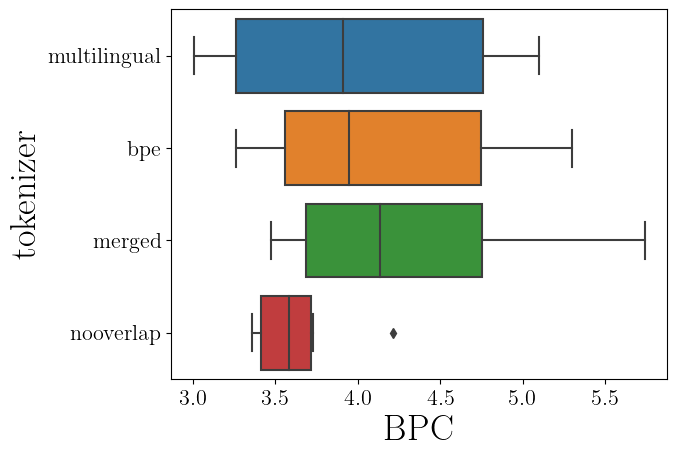

In [25]:
boxplot_across_languages(in_lang_results, 'BPC', languages)

## Down-stream task performance (POS / NER / ...)

POS

In [26]:
pos_results = dict()
pos_stds = dict()

metrics = ('accuracy','f1-macro')
for tok_type in tokenization_types:
    pos_results[tok_type], pos_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'POS',ft_type=ft_type, metrics=metrics,
                                                                        seeds=(1229, 1230, 1231, 1232, 1233))
    pos_results[tok_type] = {m : {lang: pos_results[tok_type][m][lang][lang] for lang in languages}
                             for m in metrics}
    pos_stds[tok_type] = {m: {lang: pos_stds[tok_type][m][lang][lang] for lang in languages}
                          for m in metrics}

In [27]:
for tokenization in tokenization_types:
    pos_est = {'task': 'POS', 'metric': 'F1', 'tokenizer': tokenization} 
    pos_std = {'task': 'POS', 'metric': 'F1', 'tokenizer': tokenization} 
    
    pos_est.update(pos_results[tokenization]['f1-macro'])
    pos_est['All'] = np.average(list(pos_results[tokenization]['f1-macro'].values()))
    
    pos_std.update(pos_stds[tokenization]['f1-macro'])
    pos_std['All'] = np.average(list(pos_stds[tokenization]['f1-macro'].values()))
    

    in_lang_results = in_lang_results.append(pos_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(pos_std, ignore_index=True)

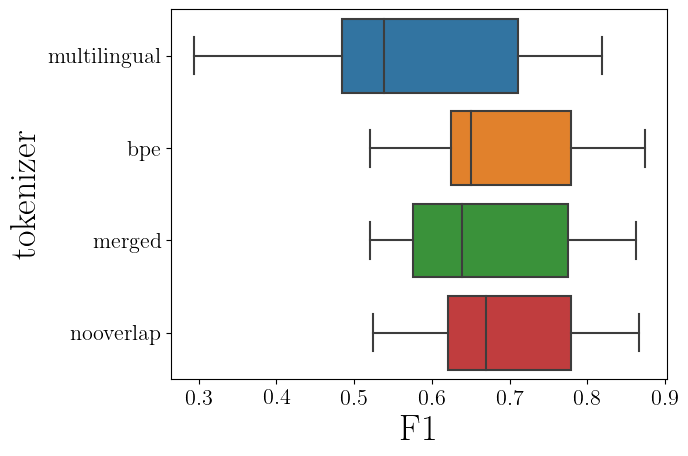

In [28]:
boxplot_across_languages(in_lang_results, 'F1', languages, task='POS')

NER

In [29]:
ner_results = dict()
ner_stds = dict()

metrics = ('f1-seqeval','f1-macro')
for tok_type in tokenization_types:
    ner_results[tok_type], ner_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'NER', ft_type=ft_type, metrics=metrics,
                                                                        seeds=(1229, 1230, 1231, 1232, 1233))
    ner_results[tok_type] = {m : {lang: ner_results[tok_type][m][lang][lang] for lang in languages}
                             for m in metrics}
    ner_stds[tok_type] = {m: {lang: ner_stds[tok_type][m][lang][lang] for lang in languages}
                          for m in metrics}

In [30]:
for tokenization in tokenization_types:
    ner_est = {'task': 'NER', 'metric': 'F1', 'tokenizer': tokenization} 
    ner_std = {'task': 'NER', 'metric': 'F1', 'tokenizer': tokenization} 
    
    ner_est.update(ner_results[tokenization]['f1-macro'])
    ner_est['All'] = np.average(list(ner_results[tokenization]['f1-macro'].values()))
    
    ner_std.update(ner_stds[tokenization]['f1-macro'])
    ner_std['All'] = np.average(list(ner_stds[tokenization]['f1-macro'].values()))
    

    in_lang_results = in_lang_results.append(ner_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(ner_std, ignore_index=True)

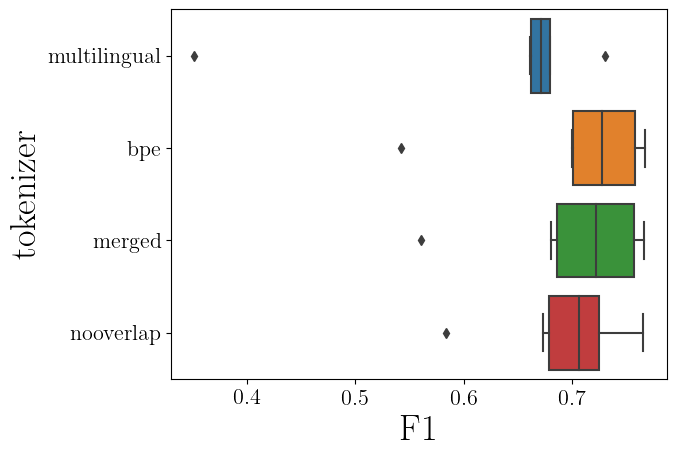

In [31]:
boxplot_across_languages(in_lang_results, 'F1', languages, task='NER')

## XNLI

In [32]:
xnli_results = dict()
xnli_stds = dict()

metrics = ('accuracy',)
for tok_type in tokenization_types:
    xnli_results[tok_type], xnli_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'XNLI', ft_type=ft_type, metrics=metrics,
                                                                        seeds=(2000, 2001, 2002, 2003, 2004))
    xnli_results[tok_type] = {m : {lang: xnli_results[tok_type][m][lang][lang] for lang in languages}
                             for m in metrics}
    xnli_stds[tok_type] = {m: {lang: xnli_stds[tok_type][m][lang][lang] for lang in languages}
                          for m in metrics}

In [33]:
for tokenization in tokenization_types:
    xnli_est = {'task': 'XNLI', 'metric': 'Acc', 'tokenizer': tokenization} 
    xnli_std = {'task': 'XNLI', 'metric': 'Acc', 'tokenizer': tokenization} 
    
    xnli_est.update(xnli_results[tokenization]['accuracy'])
    xnli_est['All'] = np.average(list(xnli_results[tokenization]['accuracy'].values()))
    
    xnli_std.update(xnli_stds[tokenization]['accuracy'])
    xnli_std['All'] = np.average(list(xnli_stds[tokenization]['accuracy'].values()))
    

    in_lang_results = in_lang_results.append(xnli_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(xnli_std, ignore_index=True)

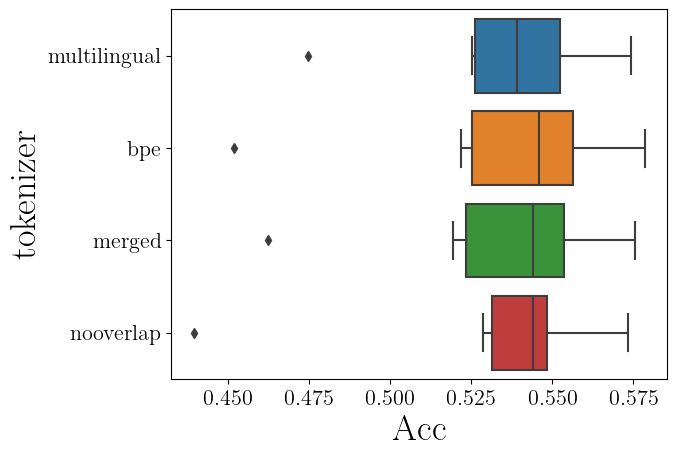

In [34]:
boxplot_across_languages(in_lang_results, 'Acc', languages, task='XNLI')

# Table Results

In [35]:
in_lang_results.sort_values(["task", "metric"])

,task,metric,tokenizer,ar,tr,zh,el,es,en,All
12,LM,BPC,multilingual,5.097600,4.461929,4.854915,3.361697,3.005752,3.232518,4.002402
13,LM,BPC,bpe,5.296284,4.124096,4.954015,3.773821,3.263734,3.485973,4.149654
14,LM,BPC,merged,5.736469,4.930816,4.047776,4.219898,3.475078,3.563784,4.328970
15,LM,BPC,nooverlap,4.213453,3.686561,3.475444,3.729018,3.391138,3.357289,3.642150
8,LM,MRR,multilingual,0.359685,0.360099,0.341552,0.463133,0.496743,0.495787,0.419500
9,LM,MRR,bpe,0.287334,0.335945,0.286264,0.385598,0.430695,0.409817,0.355942
10,LM,MRR,merged,0.315037,0.305593,0.382171,0.412005,0.453381,0.455806,0.387332
11,LM,MRR,nooverlap,0.381145,0.396091,0.414300,0.428457,0.475431,0.466204,0.426938
20,NER,F1,multilingual,0.663766,0.730154,0.351097,0.679533,0.679652,0.661139,0.627557
21,NER,F1,bpe,0.760502,0.766765,0.542170,0.702742,0.752260,0.699755,0.704032


In [36]:
in_lang_stds.sort_values(["task", "metric"])

,task,metric,tokenizer,ar,tr,zh,el,es,en,All
12,LM,BPC,multilingual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,LM,BPC,bpe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,LM,BPC,merged,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,LM,BPC,nooverlap,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,LM,MRR,multilingual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,LM,MRR,bpe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,LM,MRR,merged,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,LM,MRR,nooverlap,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20,NER,F1,multilingual,0.000725,0.001157,0.001030,0.001035,0.000814,0.001519,0.001047
21,NER,F1,bpe,0.000462,0.000496,0.001462,0.001256,0.000925,0.000436,0.000840


In [37]:
def format_text(mean, std=0. ,mult=1., dec=1, with_stds=False):
    mean = round(mean * mult, dec)
    std = round(std * mult, dec)
    if dec == 0:
        mean = int(mean)
        std = int(mean)
        
    if mean is np.nan:
        return "-"

    if with_stds:
        return f"{mean} $_{{\pm{std}}}$"
    else:
        return f"{mean}"



def preprocess_table(table):
    table['metric'] = [r[1]['task'] if r[1]['task']  not in ('allocation', 'LM')
              else r[1]['metric'] for r in table.iterrows()]
    table= table.drop(columns=['task'])
    
    table = table[table['metric']  != 'BPC']
    table = table.replace({'tokenizer': name_map})
    table.set_index(['metric', 'tokenizer'], inplace=True)
    return table


def textify_results(res, stds):
    for i, row in res.iterrows():
        if i[0] == 'Avg. Rank':
            res.loc[i] = [format_text(v, dec=0) for v in row]
        elif i[0] == 'CPT':
            res.loc[i] = [format_text(v, dec=2) for v in row]
        elif i[0] == 'MRR':
            res.loc[i] = [format_text(v, mult=100.) for v in row]
        else:
            res.loc[i] = [format_text(v, std=s, mult=100., with_stds=True) for v, s in zip(row, stds.loc[i])]

    return res
    


In [38]:
tab_res = preprocess_table(in_lang_results)
tab_std = preprocess_table(in_lang_stds)

out_in_lang = textify_results(tab_res, tab_std)
out_in_lang

ar                tr                zh  \
metric    tokenizer                                                         
Avg. Rank Unigram                2129              2719              5919   
          BPE                    2972              3226              4294   
          TokMix                 3485              4167              3961   
          NoOverlap              2537              2653              2090   
CPT       Unigram                3.16              4.01              1.84   
          BPE                     3.7              4.19              2.03   
          TokMix                  3.7              4.45              1.73   
          NoOverlap              3.53              4.19              1.56   
MRR       Unigram                36.0              36.0              34.2   
          BPE                    28.7              33.6              28.6   
          TokMix                 31.5              30.6              38.2   
          NoOverlap              38.1              39.6              41.4   
POS       Unigram    54.8 $_{\pm0.1}$  46.9 $_{\pm0.2}$  29.3 $_{\pm0.1}$   
          BPE        66.7 $_{\pm0.1}$  52.1 $_{\pm0.1}$  62.2 $_{\pm0.0}$   
          TokMix     66.0 $_{\pm0.1}$  52.1 $_{\pm0.2}$  56.2 $_{\pm0.0}$   
          NoOverlap  66.5 $_{\pm0.1}$  52.5 $_{\pm0.2}$  60.6 $_{\pm0.1}$   
NER       Unigram    66.4 $_{\pm0.1}$  73.0 $_{\pm0.1}$  35.1 $_{\pm0.1}$   
          BPE        76.1 $_{\pm0.0}$  76.7 $_{\pm0.0}$  54.2 $_{\pm0.1}$   
          TokMix     76.6 $_{\pm0.1}$  76.2 $_{\pm0.1}$  56.1 $_{\pm0.0}$   
          NoOverlap  76.5 $_{\pm0.1}$  72.8 $_{\pm0.0}$  58.4 $_{\pm0.1}$   
XNLI      Unigram    52.5 $_{\pm0.3}$  52.9 $_{\pm0.3}$  47.5 $_{\pm1.4}$   
          BPE        52.2 $_{\pm0.3}$  53.6 $_{\pm0.5}$  45.2 $_{\pm0.4}$   
          TokMix     52.0 $_{\pm0.2}$  53.6 $_{\pm0.5}$  46.2 $_{\pm1.0}$   
          NoOverlap  52.9 $_{\pm0.7}$  54.0 $_{\pm0.2}$  44.0 $_{\pm0.8}$   

                                   el                es                en  \
metric    tokenizer                                                         
Avg. Rank Unigram                2070              1439              1513   
          BPE                    2907              2220              2143   
          TokMix                 2639              1999              1898   
          NoOverlap              2065              1661              1597   
CPT       Unigram                 3.5              3.88              3.91   
          BPE                    3.97              4.34              4.22   
          TokMix                  3.9              4.24              4.18   
          NoOverlap              3.81              4.15              4.15   
MRR       Unigram                46.3              49.7              49.6   
          BPE                    38.6              43.1              41.0   
          TokMix                 41.2              45.3              45.6   
          NoOverlap              42.8              47.5              46.6   
POS       Unigram    52.9 $_{\pm0.3}$  76.5 $_{\pm0.2}$  81.9 $_{\pm0.1}$   
          BPE        63.4 $_{\pm0.1}$  81.7 $_{\pm0.4}$  87.4 $_{\pm0.1}$   
          TokMix     61.7 $_{\pm0.2}$  81.3 $_{\pm0.2}$  86.3 $_{\pm0.1}$   
          NoOverlap  67.5 $_{\pm0.1}$  81.3 $_{\pm0.6}$  86.7 $_{\pm0.1}$   
NER       Unigram    68.0 $_{\pm0.1}$  68.0 $_{\pm0.1}$  66.1 $_{\pm0.2}$   
          BPE        70.3 $_{\pm0.1}$  75.2 $_{\pm0.1}$  70.0 $_{\pm0.0}$   
          TokMix     70.1 $_{\pm0.1}$  74.3 $_{\pm0.1}$  68.1 $_{\pm0.1}$   
          NoOverlap  69.6 $_{\pm0.1}$  71.6 $_{\pm0.1}$  67.3 $_{\pm0.1}$   
XNLI      Unigram    55.0 $_{\pm0.2}$  55.3 $_{\pm0.3}$  57.4 $_{\pm0.5}$   
          BPE        55.6 $_{\pm0.3}$  55.7 $_{\pm0.2}$  57.8 $_{\pm0.2}$   
          TokMix     55.4 $_{\pm0.3}$  55.3 $_{\pm0.1}$  57.5 $_{\pm0.2}$   
          NoOverlap  54.8 $_{\pm0.1}$  54.9 $_{\pm0.3}$  57.3 $_{\pm0.3}$   

                             

In [39]:
out_in_lang.to_latex(os.path.join(TABLE_DIR,"in_lang.tex"), index=True,multirow=True,
                          longtable=False, escape=False, encoding="UTF-8",
                   caption="Results of evaluation for in language properties and tasks for six diverse languages."
                   "We observe significant changes for different tokenization methods.",
                   label="tab:in_lang")
                   

### Aggregated table

In [40]:
out_in_lang_avg = tab_res.All.unstack(level=0).reindex(index = ['Unigram','BPE','TokMix','NoOverlap'])
out_in_lang_avg

metric,Avg. Rank,CPT,MRR,NER,POS,XNLI
tokenizer,,,,,,
Unigram,2042,3.17,42.0,62.8 $_{\pm0.1}$,57.1 $_{\pm0.2}$,53.4 $_{\pm0.5}$
BPE,2274,3.51,35.6,70.4 $_{\pm0.1}$,68.9 $_{\pm0.2}$,53.3 $_{\pm0.3}$
TokMix,2198,3.34,38.7,70.2 $_{\pm0.1}$,67.3 $_{\pm0.1}$,53.3 $_{\pm0.4}$
NoOverlap,1829,3.16,42.7,69.4 $_{\pm0.1}$,69.2 $_{\pm0.2}$,53.0 $_{\pm0.4}$


In [41]:
out_in_lang_avg.to_latex(os.path.join(TABLE_DIR,"in_lang_avg.tex"), index=True,multirow=True,
                          longtable=False, escape=False, encoding="UTF-8",
                        caption="Results of evaluation for in language properties and tasks averaged six diverse languages."
                        "We observe significant changes for different tokenization methods.",
                        label="tab:in_lang_avg")

## Pairwaise correlation analysis

In [42]:

def format_text_ca(r, p, dec=3):
    r = round(r, dec)
    if p < 0.05 and p >= 0.01:
        return  f"{r}*"
    elif p < 0.01:
        return  f"{r}**"
    else:
        return f"{r}"
    
def textify_results_ca(corr, p_val):
    for i, row in corr.iterrows():
        corr.loc[i] = [format_text_ca(c, p) for c, p in zip(row, p_val.loc[i])]

    return corr

def preprocess_table_correlations(table):
    table['metric'] = [r[1]['task'] if r[1]['task']  not in ('allocation', 'LM')
              else r[1]['metric'] for r in table.iterrows()]
    table= table.drop(columns=['task'])
    
    table = table[table['metric']  != 'BPC']
    table = table.replace({'tokenizer': name_map})
    #table.set_index(['metric'], inplace=True)
    
    # normalizing data by language to account for heterogenity 
    table = pd.melt(table, id_vars=['metric', 'tokenizer'],
                     value_vars=languages, var_name='language').\
                    pivot_table(columns=['metric'], values='value', index=['language', 'tokenizer']).\
                    reset_index()

    table.loc[:, ~table.columns.isin(['language', 'tokenizer'])] = table.groupby("language",).transform(lambda x: ((x - x.mean()) ),) #/ x.std() ),)
    return table


In [43]:
in_lang_ca = preprocess_table_correlations(in_lang_results)

In [44]:
in_lang_ca

metric,language,tokenizer,Avg. Rank,CPT,MRR,NER,POS,XNLI
0,ar,BPE,191.033363,0.176530,-0.048466,0.021715,0.031919,-2.015968e-03
1,ar,NoOverlap,-243.633603,0.008865,0.045345,0.026249,0.030168,4.730539e-03
2,ar,TokMix,704.538176,0.178964,-0.020763,0.027058,0.024898,-4.291417e-03
3,ar,Unigram,-651.937937,-0.364359,0.023885,-0.075022,-0.086985,1.576846e-03
4,el,BPE,487.109410,0.180148,-0.036700,0.008022,0.019991,3.922156e-03
5,el,NoOverlap,-354.951579,0.010736,0.006158,0.001136,0.061376,-4.021956e-03
6,el,TokMix,218.540778,0.102057,-0.010293,0.006029,0.003594,2.205589e-03
7,el,Unigram,-350.698610,-0.292940,0.040835,-0.015187,-0.084960,-2.105788e-03
8,en,BPE,354.799872,0.108395,-0.047087,0.020949,0.018047,3.073852e-03
9,en,NoOverlap,-191.114704,0.033025,0.009301,-0.005396,0.011452,-2.115768e-03


In [45]:
pearson_r = in_lang_ca.corr(method='pearson')
pearson_p = in_lang_ca.corr(method=lambda x, y: pearsonr(x, y)[1])

In [46]:
out_ca_in_lang = textify_results_ca(pearson_r.iloc[1:,:3], pearson_p.iloc[1:,:3])
out_ca_in_lang

metric,Avg. Rank,CPT,MRR
metric,,,
CPT,0.658**,1.0,-0.807**
MRR,-0.679**,-0.807**,1.0
NER,-0.39,0.294,-0.107
POS,-0.406*,0.362,-0.163
XNLI,0.702**,0.223,-0.169


In [47]:
out_ca_in_lang .to_latex(os.path.join(TABLE_DIR,"corr_in_lang.tex"), index=True,multirow=True,
                          longtable=False, escape=False, encoding="UTF-8",
                        caption="Correlations between task performance metrics and tokenizer measures."
                         "Stars denote statistical significance: (* coresponeds to $p<0.05$ and ** to $p<0.01$).",
                        label="tab:corr_in_lang")

Plotting pairwais corrlation plots

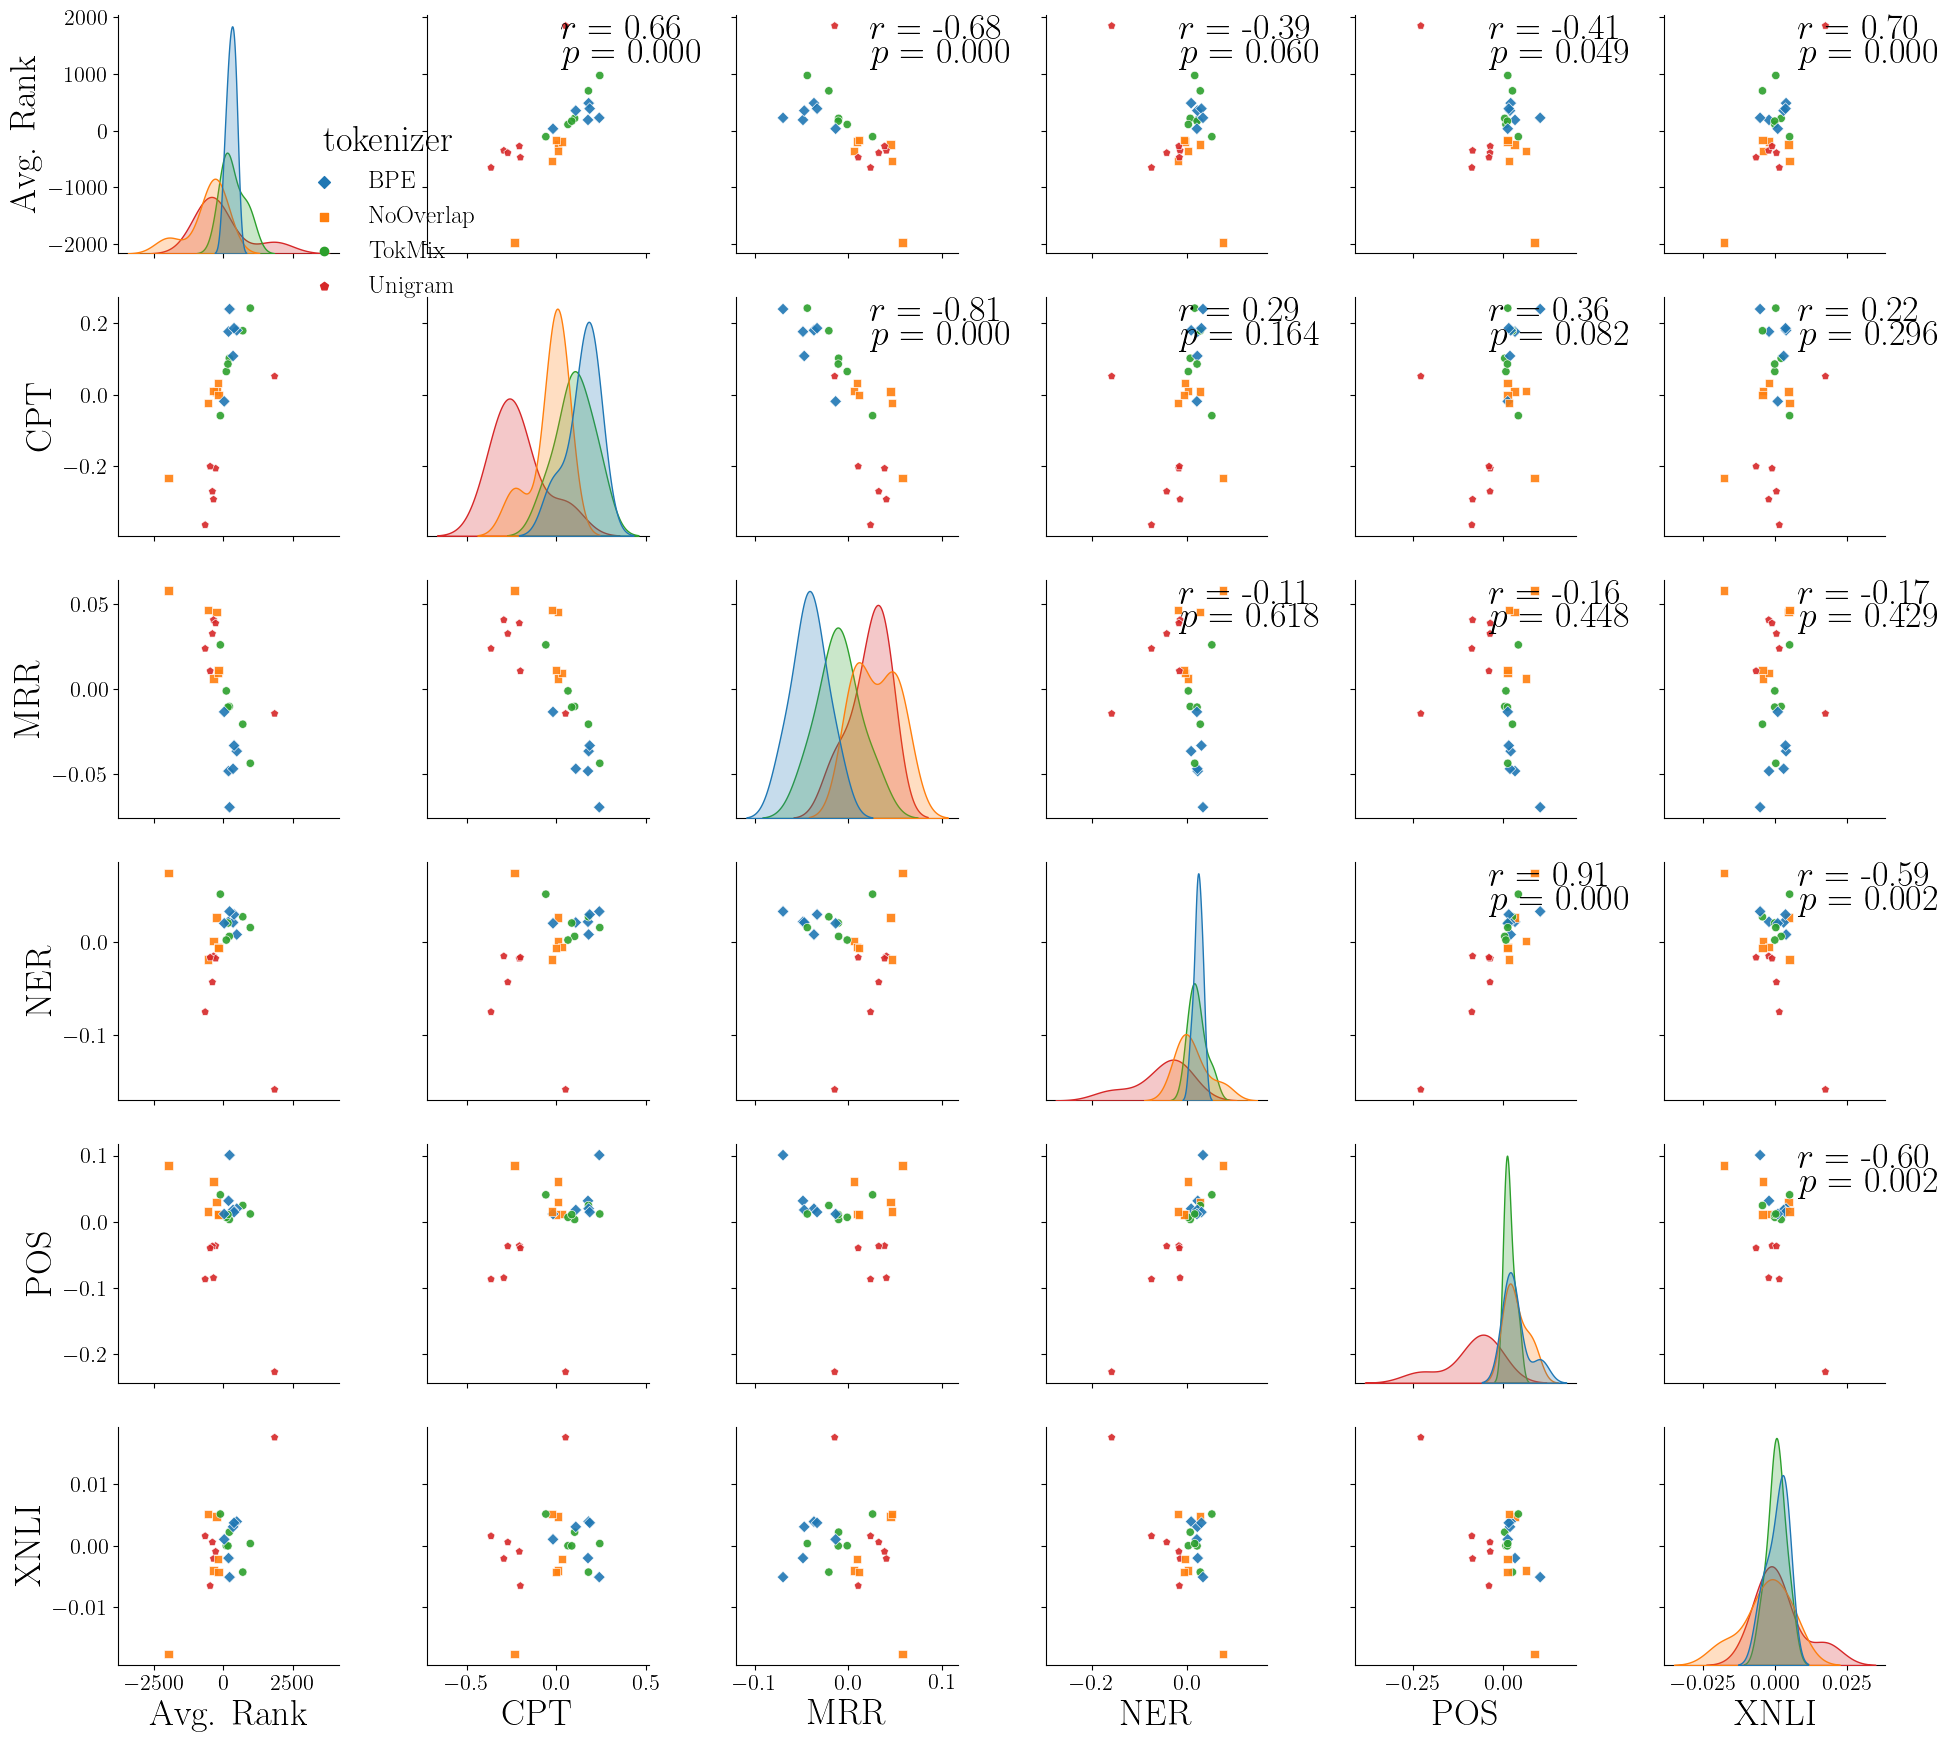

In [48]:
# spearman_r = in_lang_ca.corr(method='spearman').to_numpy()
# spearman_p = in_lang_ca.corr(method=lambda x, y: spearmanr(x, y)[1]).to_numpy()

#plt.figure(figsize=(3.5,3.5))
plot1 = sns.pairplot(in_lang_ca, hue="tokenizer",
                     markers=['D','s', 'o', 'p', 'X'],
                     plot_kws={'alpha': 0.9},
                    size=3)

plot1._legend.set_bbox_to_anchor((.25, 0.85))
# plt.legend(loc='center right', title='Type')
plot1.map
axes = plot1.axes
for i in range(len(in_lang_ca.columns) - 3):
    for j in range(i+1,len(in_lang_ca.columns)-2):
        ax = axes[i][j]
        r = pearson_r.to_numpy()[i,j]
        p = pearson_p.to_numpy()[i,j]
        ax.annotate(r"$r$ = {:.2f}".format(r), xy=(.6, .9), xycoords=ax.transAxes)
        ax.annotate(r"$p$ = {:0.3f}".format(p), xy=(.6, .8), xycoords=ax.transAxes)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "pair_analysis.pdf"), dpi=300)
